In [1]:
import cartopy.crs as ccrs
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KernelDensity

In [2]:
real = pd.read_pickle('../data_cabspotting/cabspotting_cut.pkl')
fake = pd.read_pickle('../data_berlinmod/trips_cabspotting.pkl')

In [14]:
fake.head()

trip   longitude   latitude
user time                                                
1    2008-06-01 00:00:00.000     1 -122.511865  37.779656
     2008-06-02 07:19:44.460     2 -122.511865  37.779656
     2008-06-02 07:19:45.542     2 -122.511842  37.779656
     2008-06-02 07:19:45.877     2 -122.511820  37.779565
     2008-06-02 07:19:46.313     2 -122.511820  37.779565

In [3]:
# Load the OSMNX graphs
streets_small = ox.load_graphml('san_francisco_streets_all.graphml', folder='../osmnx_data')

In [4]:
streets = ox.load_graphml('cabspotting_streets_all.graphml', folder='../osmnx_data')

## Simple overview (small map)

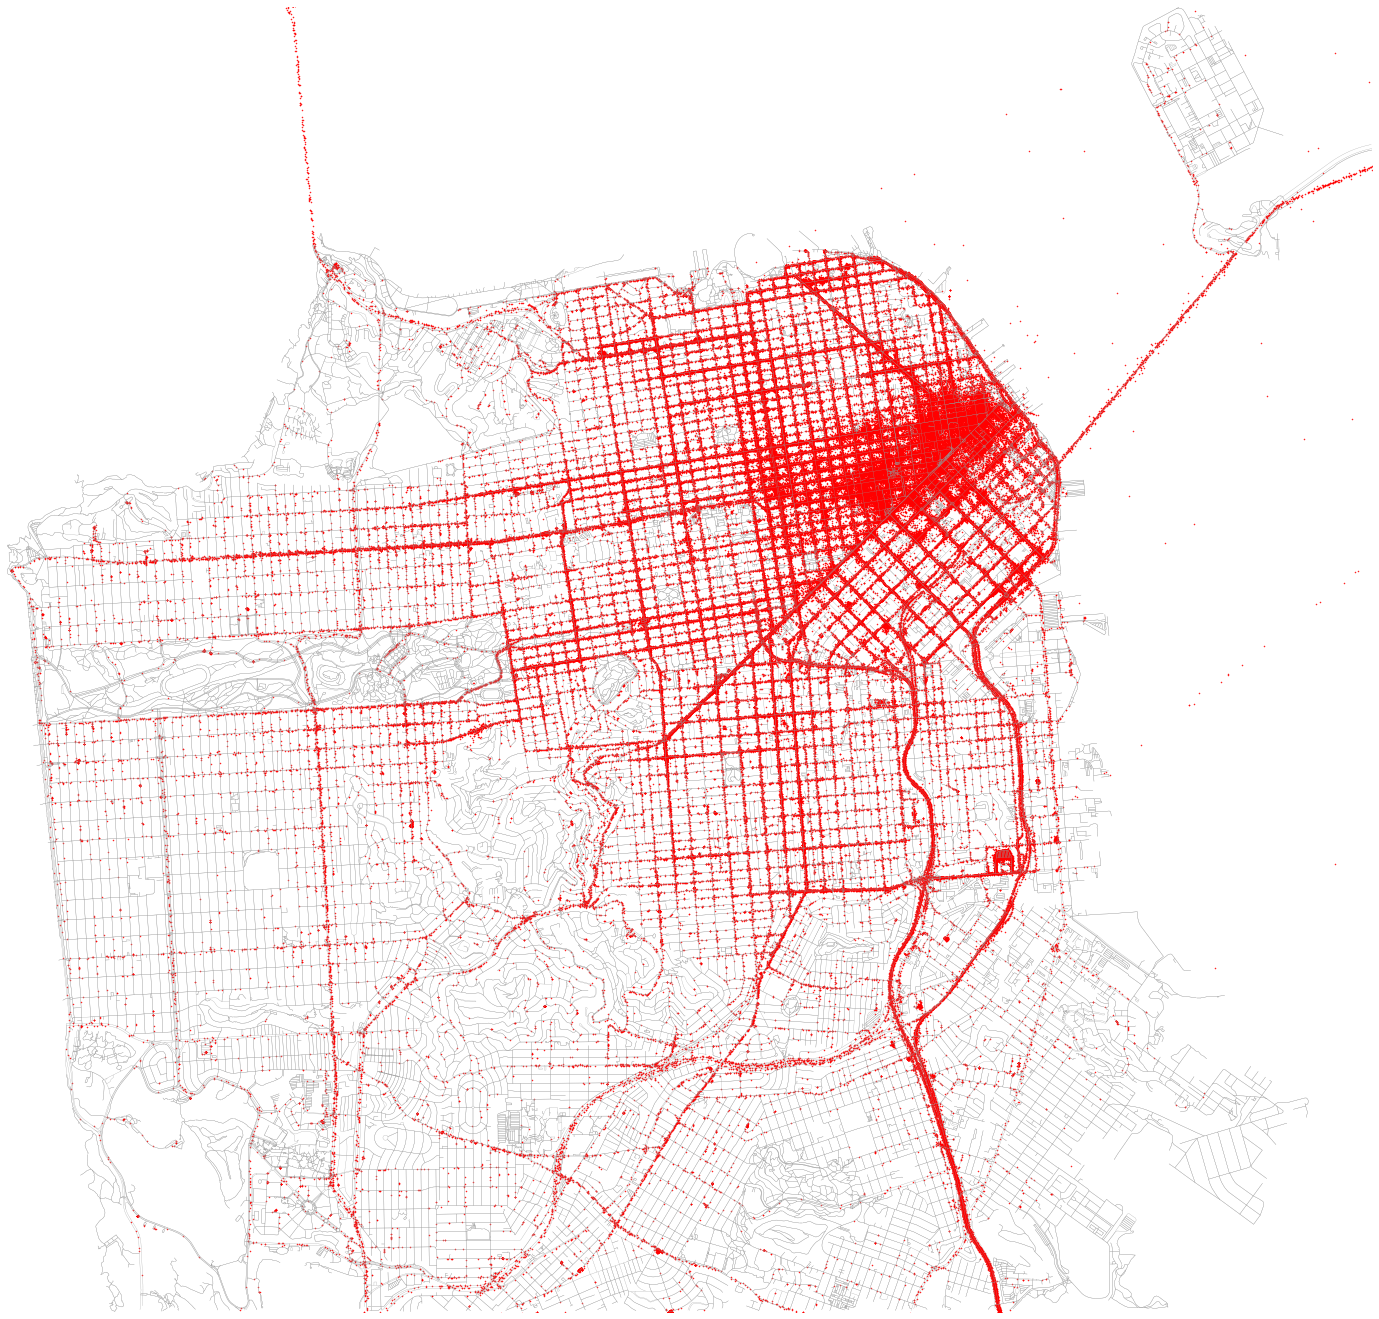

In [6]:
fig, ax = ox.plot_graph(streets_small, fig_height=24, node_size=0, edge_linewidth=0.25, margin=0.0,
                        show=False, close=False)
ax.scatter(real['longitude'], real['latitude'], c='#ff0000', s=0.25, alpha=1.0)

plt.savefig('../../Images/question_overview_cabspotting_real.png', dpi=100, bbox_inches='tight')

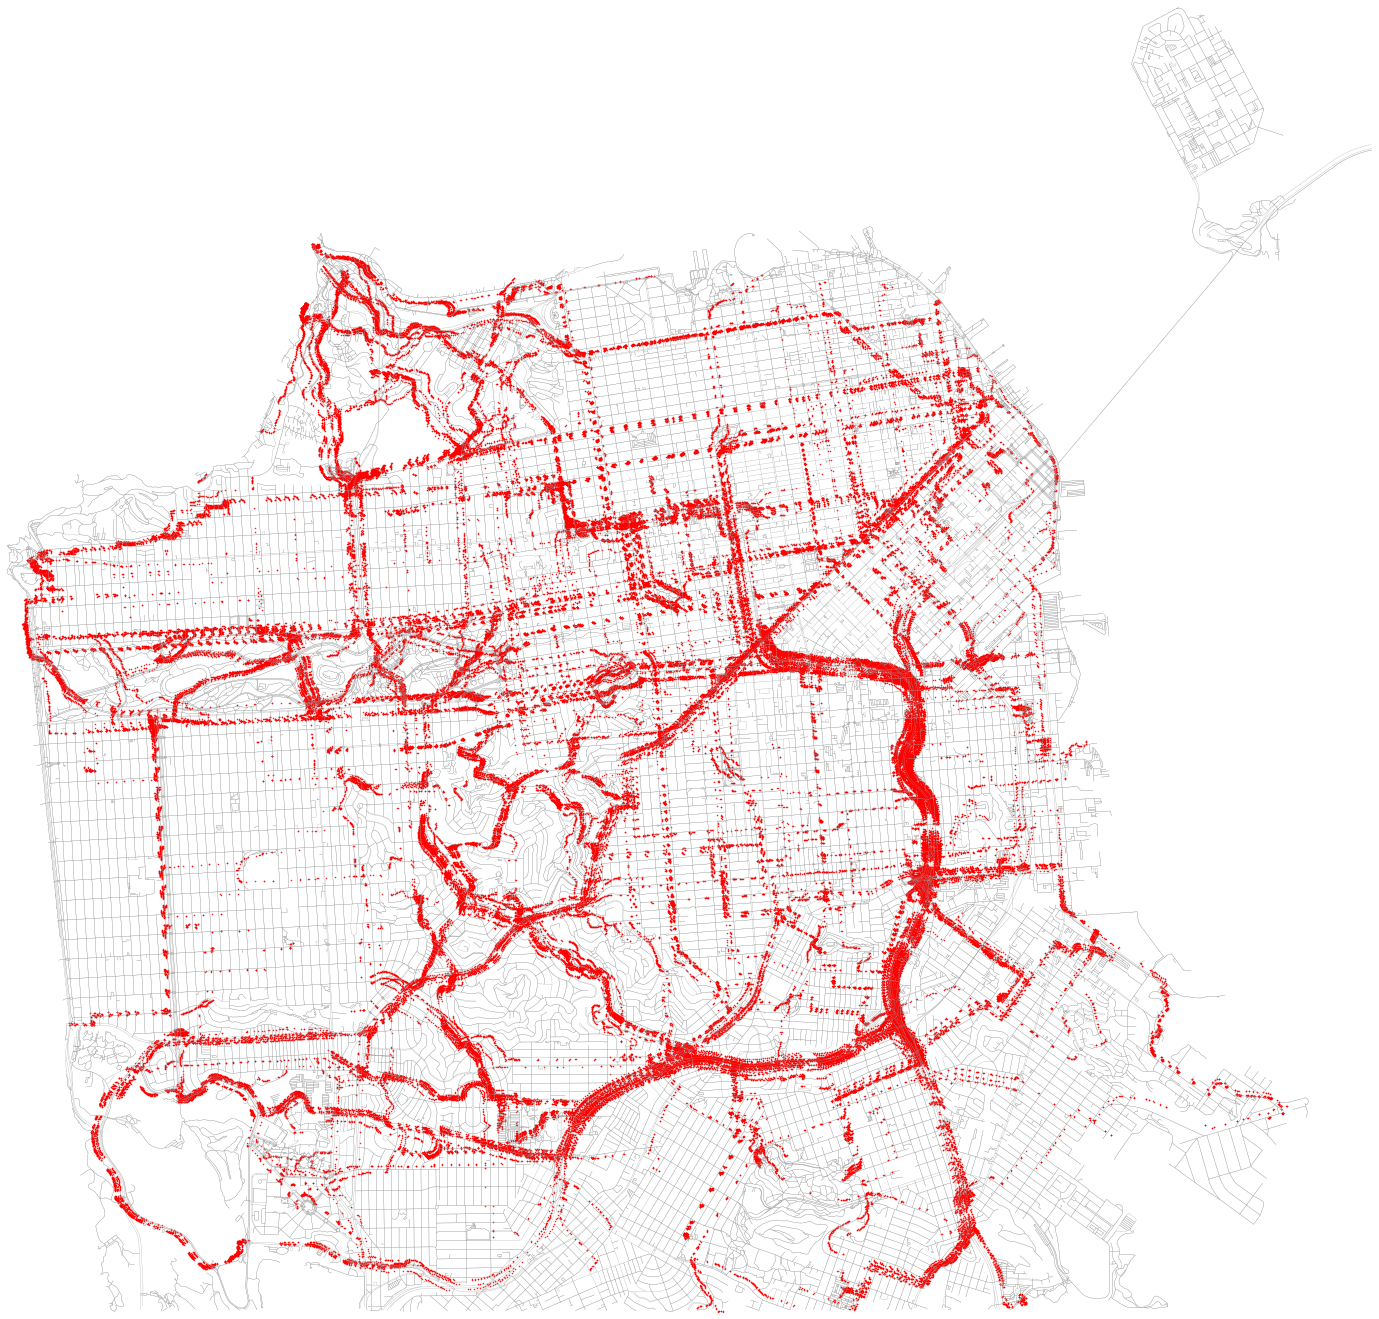

In [7]:
fig, ax = ox.plot_graph(streets_small, fig_height=24, node_size=0, edge_linewidth=0.25, margin=0.0,
                        show=False, close=False)
ax.scatter(fake['longitude'], fake['latitude'], c='#ff0000', s=0.25, alpha=1.0)

plt.savefig('../../Images/question_overview_cabspotting_berlinmod.png', dpi=100, bbox_inches='tight')

## Simplex overview (large map)

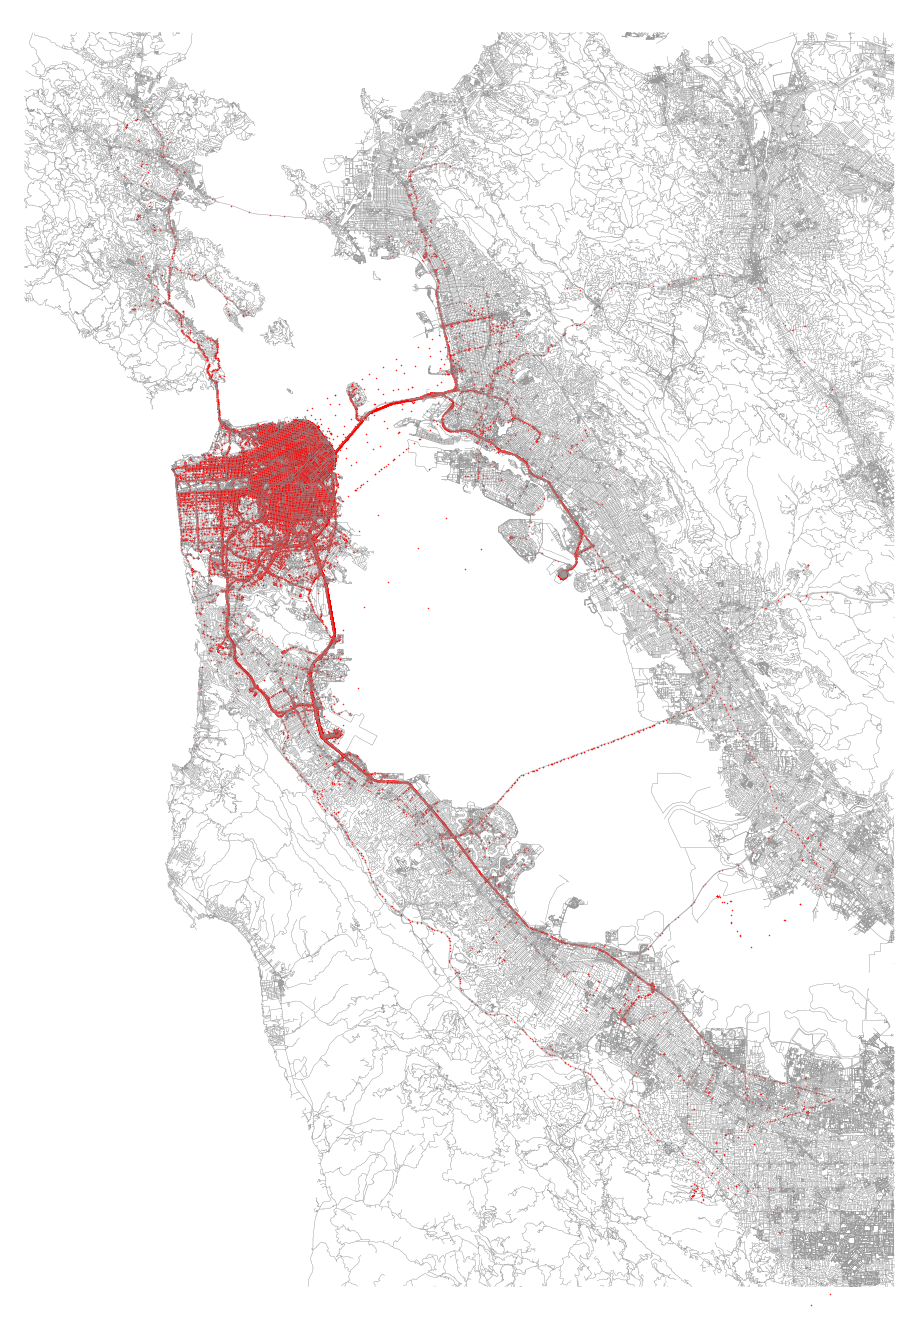

In [6]:
fig, ax = ox.plot_graph(streets, fig_height=24, node_size=0, edge_linewidth=0.25, show=False, close=False)
ax.scatter(real['longitude'], real['latitude'], c='#ff0000', s=0.25, alpha=1.0)

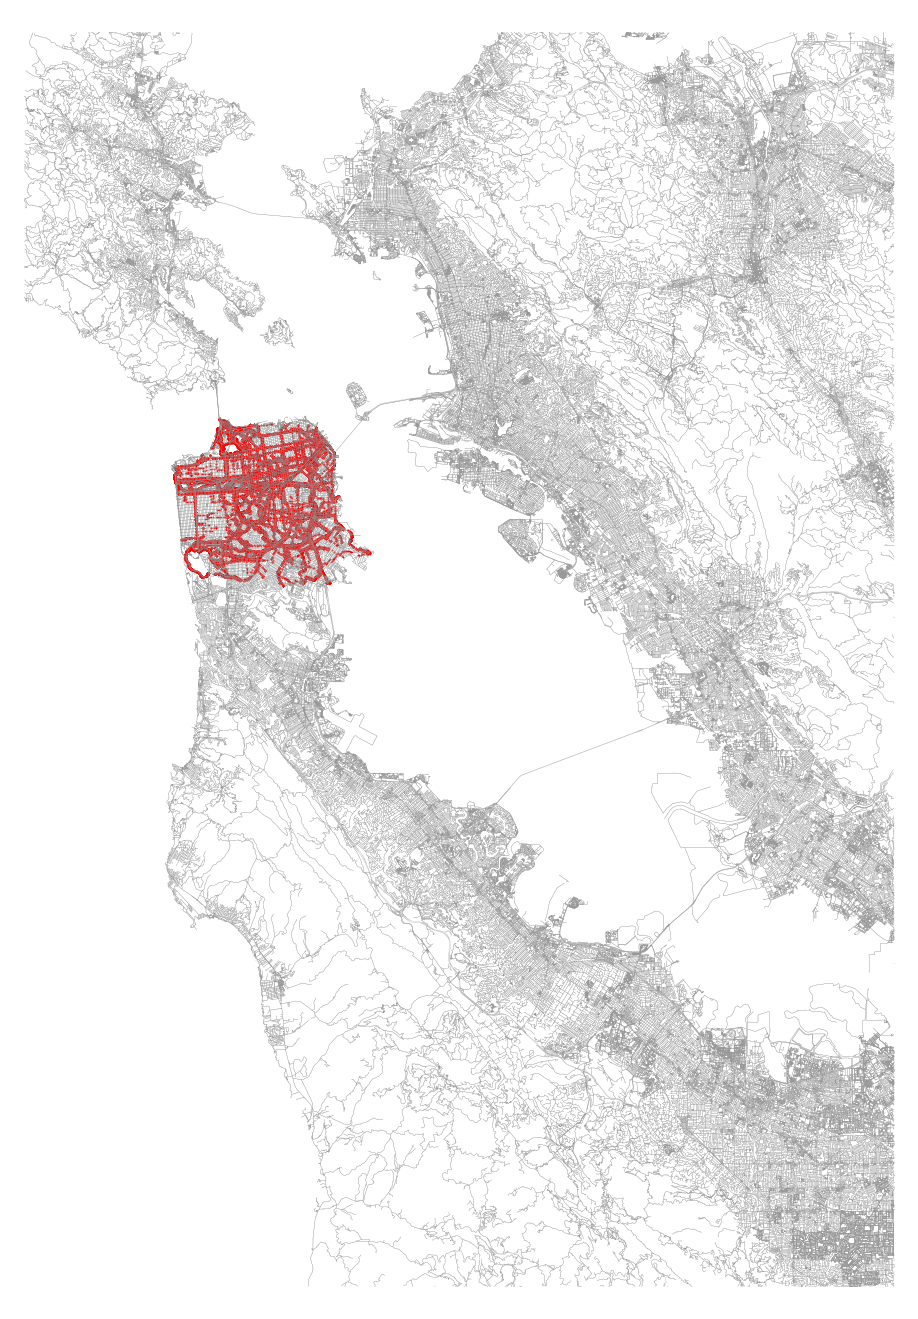

In [16]:
fig, ax = ox.plot_graph(streets, fig_height=24, node_size=0, edge_linewidth=0.25, show=False, close=False)
ax.scatter(fake['longitude'], fake['latitude'], c='#ff0000', s=0.25, alpha=1.0)

## Histogram of # records in every hour

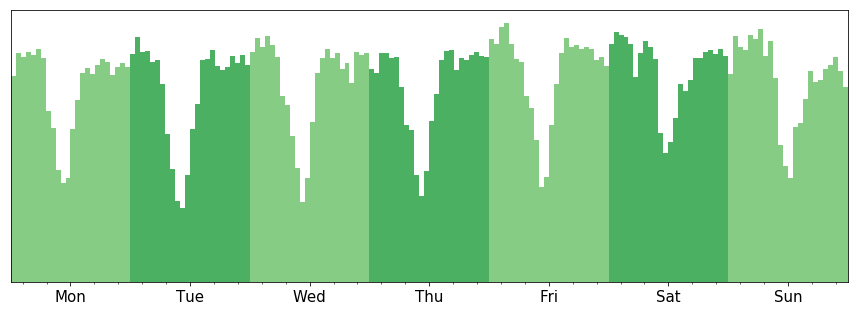

In [8]:
plt.figure(figsize=(15, 5))
_, _, patches = plt.hist(real.index.levels[1], bins=168,
                         range=(pd.Timestamp('2008-06-02 00:00:00'), pd.Timestamp('2008-06-08 23:59:59')))
cm = plt.cm.Greens
colours = ([0.45]*24 + [0.6]*24)*7
for c, p in zip(colours, patches):
    plt.setp(p, 'facecolor', cm(c))
plt.xlim(pd.Timestamp('2008-06-02 00:00:00'), pd.Timestamp('2008-06-08 23:59:59'))
plt.xticks([pd.Timestamp('2008-06-02 12:00:00'), pd.Timestamp('2008-06-03 12:00:00'),
           pd.Timestamp('2008-06-04 12:00:00'), pd.Timestamp('2008-06-05 12:00:00'),
           pd.Timestamp('2008-06-06 12:00:00'), pd.Timestamp('2008-06-07 12:00:00'),
           pd.Timestamp('2008-06-08 12:00:00')], 
           ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.yticks([])
plt.minorticks_on()
plt.tick_params(labelsize=15.0)

plt.savefig('../../Images/question_traffic_cabspotting_real.pdf', dpi=20, bbox_inches='tight')

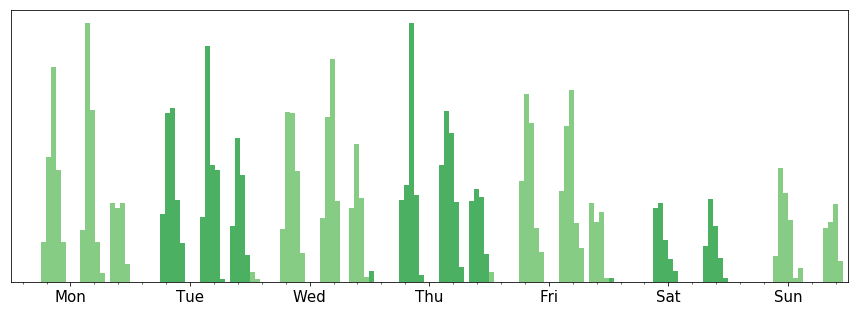

In [9]:
plt.figure(figsize=(15, 5))
_, _, patches = plt.hist(fake.index.levels[1], bins=168,
                         range=(pd.Timestamp('2008-06-02 00:00:00'), pd.Timestamp('2008-06-08 23:59:59')))
cm = plt.cm.Greens
colours = ([0.45]*24 + [0.6]*24)*7
for c, p in zip(colours, patches):
    plt.setp(p, 'facecolor', cm(c))
plt.xlim(pd.Timestamp('2008-06-02 00:00:00'), pd.Timestamp('2008-06-08 23:59:59'))
plt.xticks([pd.Timestamp('2008-06-02 12:00:00'), pd.Timestamp('2008-06-03 12:00:00'),
           pd.Timestamp('2008-06-04 12:00:00'), pd.Timestamp('2008-06-05 12:00:00'),
           pd.Timestamp('2008-06-06 12:00:00'), pd.Timestamp('2008-06-07 12:00:00'),
           pd.Timestamp('2008-06-08 12:00:00')], 
           ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.yticks([])
plt.minorticks_on()
plt.tick_params(labelsize=15.0)

plt.savefig('../../Images/question_traffic_cabspotting_berlinmod.pdf', dpi=20, bbox_inches='tight')

## Distribution of speeds

In [11]:
def haversine(lat1, lon1, lat2, lon2):
    MILES = 3959
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    total_miles = MILES * c
    return total_miles * 1.6

def speed_distribution(ds):
    tmp = ds.reset_index()
    delta_t = tmp.groupby('user')['time'].diff().dt.total_seconds()
    delta_t = delta_t / 3600.0
    prvs_poss = tmp.groupby('user')[['latitude', 'longitude']].shift(1)
    delta_w = haversine(prvs_poss['latitude'], prvs_poss['longitude'], tmp['latitude'], tmp['longitude'])
    speeds = delta_w / delta_t
    
    print(speeds.describe())
    
    plt.figure(figsize=(15, 5))
    plt.hist(speeds, bins=range(0, 150))
    plt.xlim(0, 150)
    plt.yticks([])
    plt.minorticks_on()
    plt.tick_params(labelsize=15.0)

/Users/jankaiser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in arcsin
  import sys


count    348465.000000
mean         30.417233
std        1163.740611
min           0.000000
25%           3.310669
50%          14.725242
75%          27.342158
max      614887.760159
dtype: float64


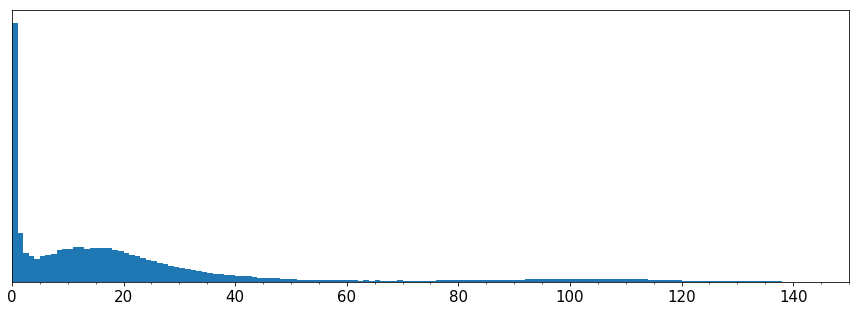

In [12]:
speed_distribution(real)
plt.savefig('../../Images/question_speeds_cabspotting_real.pdf', dpi=20, bbox_inches='tight')

/Users/jankaiser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in arcsin
  import sys


count    168433.000000
mean         52.333970
std          84.754707
min           0.000000
25%          35.292273
50%          48.298172
75%          59.487488
max       18024.689266
dtype: float64


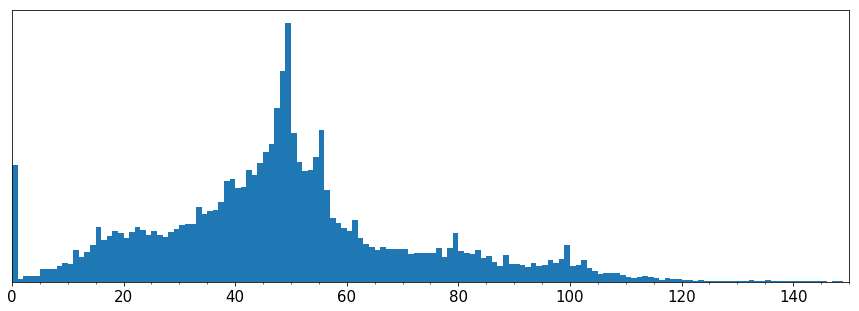

In [13]:
speed_distribution(fake)
plt.savefig('../../Images/question_speeds_cabspotting_berlinmod.pdf', dpi=20, bbox_inches='tight')

## One user's data

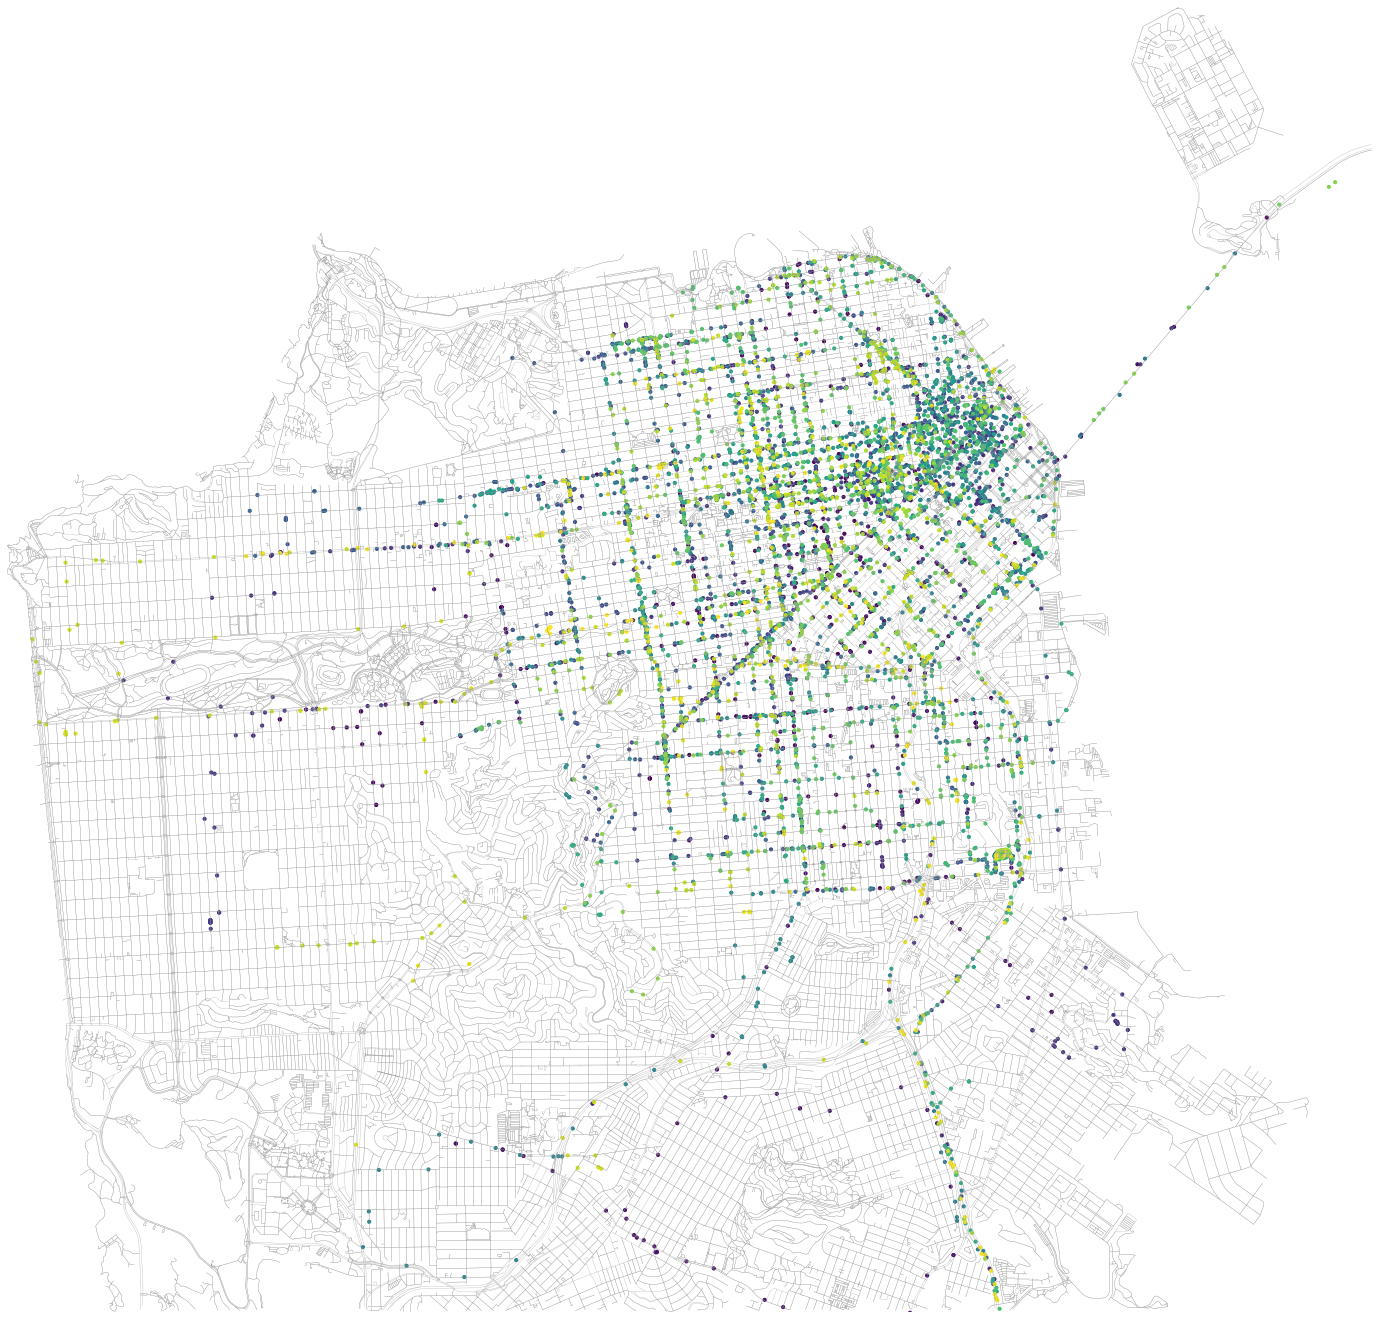

In [14]:
user = 'ektamy'
fig, ax = ox.plot_graph(streets_small, fig_height=24, node_size=0, edge_linewidth=0.25, margin=0.0,
                        show=False, close=False)
ax.scatter(real.loc[user]['longitude'], real.loc[user]['latitude'], c=real.loc[user].index, s=10.0, alpha=1.0)

plt.savefig('../../Images/question_single_cabspotting_real.png', dpi=100, bbox_inches='tight')

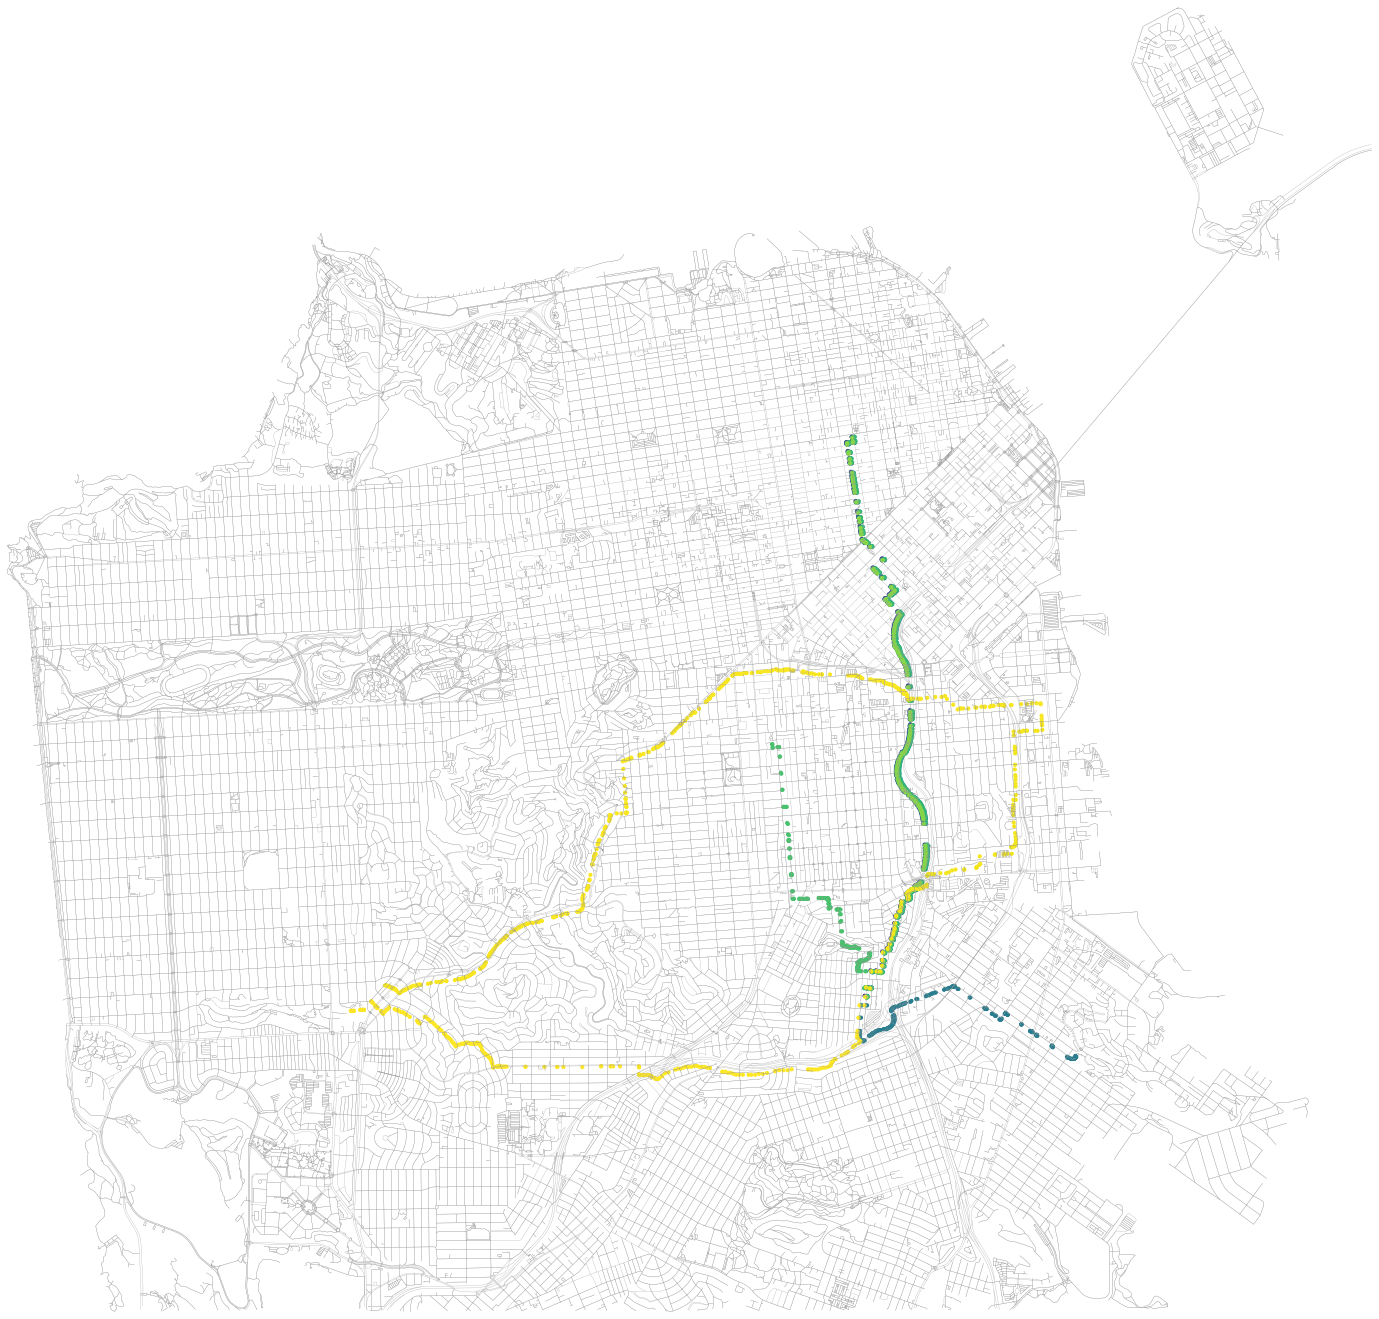

In [15]:
user = 4
fig, ax = ox.plot_graph(streets_small, fig_height=24, node_size=0, edge_linewidth=0.25, margin=0.0,
                        show=False, close=False)
ax.scatter(fake.loc[user]['longitude'], fake.loc[user]['latitude'], c=fake.loc[user].index, s=10.0, alpha=1.0)

plt.savefig('../../Images/question_single_cabspotting_berlinmod.png', dpi=100, bbox_inches='tight')